# <b>Building a Chatbot from Scratch 


##### <b>In this project we will build a chatbot from scratch using the corenell University's Movie Dialogue corpus.
##### <i><b>We will be using a deep learning based architecture with the main components as a lstm based encoder and decoder.

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, model_from_json
import keras
import nltk
import numpy as np
import sklearn
nltk.download('punkt')

Instructions for updating:
non-resource variables are not supported in the long term
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


True

Download the glove model available at https://nlp.stanford.edu/projects/glove/

Specification : Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip


you can download it with 'wget' or can directly put the embedding zip file inside 'embedding_data' folder and unzip it.

In [0]:
# ! curl -O http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip 

In [0]:
RAND_STATE=np.random.seed(42)
BATCH_SIZE = 32
NUM_EPOCHS = 10
GLOVE_EMBEDDING_SIZE = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = '/content/drive/My Drive/Chatbot/Chatbot'
DATA_PATH = '/content/drive/My Drive/Chatbot/Chatbot/movie_lines_cleaned.txt'
GLOVE_MODEL = "/content/drive/My Drive/glove.twitter.27B.100d.txt"
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
WEIGHT_FILE_PATH =  DATA_SET_NAME + '/word-glove-weights.h5'

In [0]:
def in_white_list(_word):
    return set(_word) <= set(WHITELIST)
#   '''Check if the characters in the words are whitelisted'''

Load the glove word embedding in to a dictionary where the **key** is a unique **word token** and the **value** is a **d** dimension vector 

# Test-1

In [0]:
def load_glove_vector():
    _word2embedding = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        '''write here. write your code to load the data in to the dictionary
        make sure the value is a numpy array of size 100
        max  3 to 6 lines of code'''
        words = line.strip().split()
        word = words[0]
        embedding = np.array(words[1:], dtype=np.float32)
        _word2embedding[word] = embedding        
    file.close()
    return _word2embedding

In [0]:
word2embedding = load_glove_vector()

In [7]:
assert len(word2embedding.keys())==1193514
for key in word2embedding.keys():
    try:
        assert len(word2embedding[key])==100
    except AssertionError:
        print (key,len(word2embedding[key]))  

-0.32053 99


# Data Preparation

In [0]:
target_counter = Counter()
lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
prev_words = []

In [0]:
for line in lines:
    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]
    if len(prev_words) > 0:
        input_texts.append(prev_words)
        target_words = next_words[:]
        target_words.insert(0, 'start')
        target_words.append('end')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)
    prev_words = next_words

Filter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put **start** and **end** token to recognise the beginning and end of the sentence token.

## <b>Let's see some of the training examples

In [10]:
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx > 10:
        break
    print([input_words, target_words])

[['they', 'do', 'not', '!'], ['start', 'they', 'do', 'to', '!', 'end']]
[['they', 'do', 'to', '!'], ['start', 'i', 'hope', 'so', '.', 'end']]
[['i', 'hope', 'so', '.'], ['start', 'she', 'okay', '?', 'end']]
[['she', 'okay', '?'], ['start', 'let', "'s", 'go', '.', 'end']]
[['let', "'s", 'go', '.'], ['start', 'wow', 'end']]
[['wow'], ['start', 'okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.', 'end']]
[['okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.'], ['start', 'no', 'end']]
[['no'], ['start', 'i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?', 'end']]
[['i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?'], ['start', 'like', 'my', 'fear', 'of', 'wearin

### Create two dictionaries 
<ol>
<li>target_word2id
<li>target_id2word
</ol>
and save it as NumPy file format in the disk.
<p>
<strong>NOTE:</strong> The ids should start from 1 beacause <strong>0</strong> is reserved for <strong>'unknown'</strong> tokens.
Make sure you cosider only the <strong>most common</strong> tokens with <strong>MAX_VOCAB_SIZE</strong> defined above.

Most common refers to tokens with higher frequency. 
</p>
<strong>Help:</strong>
<ol>
<li>Use the target_counter which have the token counts.  
<li>Use target_counter.most_common(MAX_VOCAB_SIZE) to filter common tokens
    </ol>

In [0]:
target_word2idx = dict()
'''create a target word to id dictionary called target_word2idx.
2 to 3 lines '''
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1
    
if 'unk' not in target_word2idx:
    target_word2idx['unk'] = 0

# '''create a target to id diilter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put **start** and **end** token to recognise the beginning and end of the sentence token.

## Let's see some of the training examplesctionary called target_idx2word . Approx ~1 line'''
target_idx2word = {value: key for key, value in target_word2idx.items() }

num_decoder_tokens = len(target_idx2word)

np.save( DATA_SET_NAME + '/word-glove-target-word2idx.npy', target_word2idx)
np.save( DATA_SET_NAME + '/word-glove-target-idx2word.npy', target_idx2word)

## CHECK 2

In [0]:
assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE+1

# <b>Prepare the input data with embedding</b>
The input data is a list of lists 
<ol>
<li> First list is a list of sentences
<li> Each sentence is a list of words
 </ol>

In [13]:
input_texts_word2em = []
encoder_max_seq_length = 0
decoder_max_seq_length = 0

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        '''enter your code here.
        '''
        embedding = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
        if w in word2embedding:
            embedding = word2embedding[w]
        encoder_input_wids.append(embedding)
        

    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
np.save( DATA_SET_NAME + '/word-glove-context.npy', context)

{'num_decoder_tokens': 10001, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


In [0]:
for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
    assert (len(input_text)==len(input_texts_word2em[input_text_embed]))

## GENERATE TRAINING DATA PER BATCH

generate_batch takes input embedding data (input_word2em_data) and target text data (target_texts) and returns trainable X and Y.
X is a list of [X1,X2]
where 
X1 is encoder_input_data_batch( which is created by putting the word embedding(glove vector) of the input tokens) padded in to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

X2 is decoder_input_data_batch which is created by putting the word embedding(glove vector) of the target_words tokens and padding it to a shape of (BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

Y is decoder_target_data_batch which is in shape of (BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens)
which signifies for each target token text  in the batch we have an option of any token from the vocabularu to be the next predicted word 

In [0]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length, dtype='float32', padding='post', truncating='post')
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            '''Fill your code here. 5 to 10 lines'''
            for index, target_words in enumerate(output_text_data[start:end]):
                for idx, word in enumerate(target_words):
                    word2index = target_word2idx['unk']  # default unknown
                    if word in target_word2idx:
                        word2index = target_word2idx[word]
                    if word in word2embedding:
                        decoder_input_data_batch[index, idx, :] = word2embedding[word]
                    if idx > 0:
                        decoder_target_data_batch[index, idx - 1, word2index] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch


## **Check-4**

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)
train_gen = generate_batch(Xtrain, Ytrain)
for i,j in train_gen:
    assert i[0].shape==(BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert i[1].shape==(BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert j.shape==(BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])

print ('Test Case 4 Passes!')

Test Case 4 Passes!


# Model Architecture 

# The Model architecture is explined in the diagram below 

# Test-5

<ol>
<li> Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
<li> Step 2:  Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state .
<li> Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
<li> Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
</ol>

In [17]:
'''write your code here.
   create a model object'''

#Encoder layers,inputs,outputs
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

#Decoder layers - input,output,LSTM,Dense
decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
#model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 365568      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  365568      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]           

## CHECK 5

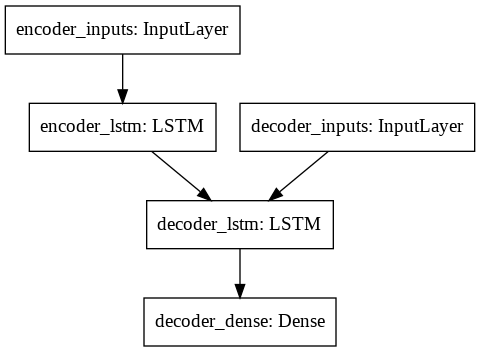

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

## <b>Training

### In case model is already trained then load the weights and run the model

In [0]:
# # load json and create model
# json_file = open('/content/drive/My Drive/Chatbot/Chatbot/colab_model.json', 'r')
# load_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(load_model_json)
# # load weights into new model
# loaded_model.load_weights("/content/drive/My Drive/Chatbot/Chatbot/colab_model.h5")
# print("Loaded model from disk")

In [20]:
#execution and updation of wt in batches
train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)

BATCH_SIZE = 100

train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

NUM_EPOCHS = 10

# train model
checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True, verbose=1)

model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    validation_data=test_gen, 
                    validation_steps=test_num_batches,
                    callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2435/2435 [==============================] - ETA: 0s - loss: 1.4565 - acc: 0.2480
Epoch 00001: val_loss improved from inf to 1.37323, saving model to /content/drive/My Drive/Chatbot/Chatbot/word-glove-weights.h5
2435/2435 [==============================] - 686s 282ms/step - loss: 1.4565 - acc: 0.2480 - val_loss: 1.3732 - val_acc: 0.3414
Epoch 2/10
2435/2435 [==============================] - ETA: 0s - loss: 1.3395 - acc: 0.2696
Epoch 00002: val_loss improved from 1.37323 to 1.33903, saving model to /content/drive/My Drive/Chatbot/Chatbot/word-glove-weights.h5
2435/2435 [==============================] - 700s 287ms/step - loss: 1.3395 - acc: 0.2696 - val_loss: 1.3390 - val_acc: 0.0942
Epoch 3/10
2435/2435 [==============================] - ETA: 0s - loss: 1.3128 - acc: 0.3069
Epoch 00003: val_loss improved from 1.33903 to 1.32462, saving model to /content/drive/My Drive/Chatbot/Chatbot/word-glove-weig

## SAVING THE MODEL

In [21]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Chatbot/Chatbot/colab_new_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Chatbot/Chatbot/colab_new_model.h5")
print("Saved model to disk")

Saved model to disk


# <b>Prediction



---



---

**FOR TESTING THE CHATBOT GO TO TEST_CHATBOT. ipynb**

For predictions go to the test_chatbot.ipynb